# Exploratory Data Analysis


In [1]:
import pandas as pd
import matplotlib as mpl
import IPython
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/interim/data_without_empty_smiles.csv')
df_c = pd.read_csv('../data/interim/compounds_without_empty_smiles.csv')

In [3]:
def matplotlib_settings(colors_list):
    """"Change matplotlib settings"""
    sns.set(font="Times New Roman")
    sns.set_style("white")
    sns.set_style('ticks')
    sns.set_context("paper", font_scale=2.25)
    sns.set_palette(sns.color_palette(colors_list))

    params = {'lines.linewidth': 3,
              'axes.linewidth': 2.5,
              'savefig.dpi': 300,
              'xtick.major.width': 2.5,
              'ytick.major.width': 2.5,
              'xtick.minor.width': 1,
              'ytick.minor.width': 1,
              'font.weight': 'medium',
              'figure.figsize': (12, 8)
              }

    mpl.rcParams.update(params)
    #IPython.display.set_matplotlib_formats('retina')

#colors_MPI = ["#007675","#87878d","#78004b", "#33a5c3", "#ece9d4"]
#matplotlib_settings(colors_MPI)

### Experimental methods used

In [11]:
# Get percentage of datapoints measured by each experimental technique

df_meth = df.groupby(['Method']).size()
df_meth

Method
DILU     3732
EBUL     2072
GLCI     9135
GLCN     5161
GLCR    20887
HENR      252
LLCR      272
NSGC      440
OTHR      256
PHEQ      905
RADM       79
RGLC      108
SOLU     4526
STAT     2688
dtype: int64

In [12]:
df_meth.values

array([ 3732,  2072,  9135,  5161, 20887,   252,   272,   440,   256,
         905,    79,   108,  4526,  2688], dtype=int64)

In [13]:
sum_other = df_meth[df_meth.values < 1000].values.sum()
df_meth_sumarized = df_meth[df_meth.values >= 1000]
df_meth_sumarized['OTHR'] = sum_other
df_meth_sumarized

Method
DILU     3732
EBUL     2072
GLCI     9135
GLCN     5161
GLCR    20887
SOLU     4526
STAT     2688
OTHR     2312
dtype: int64

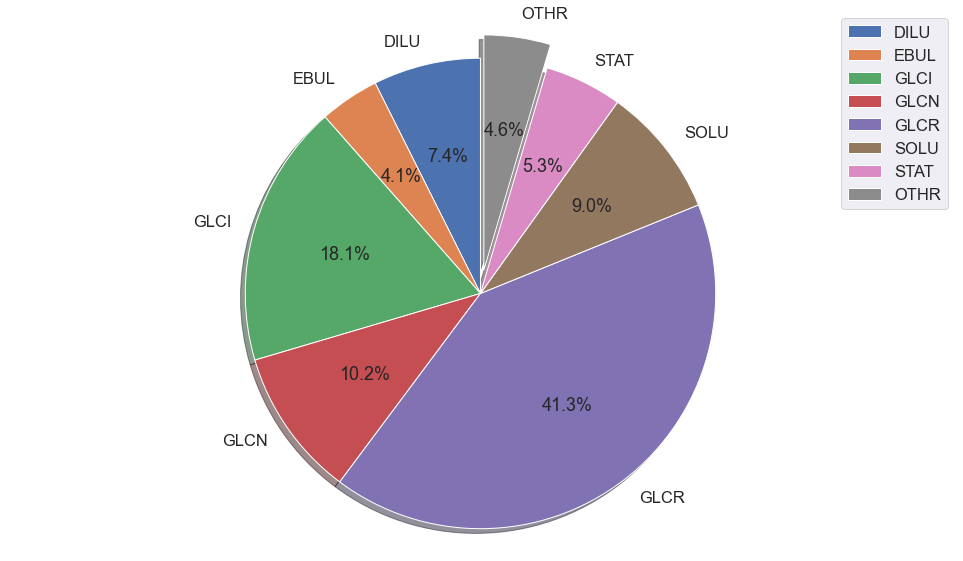

In [15]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
df_pie = df_meth_sumarized

sns.set(font_scale=1.5)
n_meth = df_pie.shape[0]
labels = df_pie.index.tolist()
sizes = df_pie.values
explode = np.zeros(n_meth)
explode[-1] = 0.1  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(17,10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend()
plt.show()
fig1.savefig('../figures/SupportingInformation/experimental_techniques.png', dpi=300, format='png')

#### Repeated_systems

In [22]:
systems_ids = {}
for i in range(df.shape[0]):
    key = df['Solvent_name'].iloc[i] + '_' + df['Solute_name'].iloc[i] + '_' + str(df['T'].iloc[i])
    if key not in systems_ids:
        systems_ids[key] = 1
    else:
        systems_ids[key] += 1

reapeated_systems = 0
for sys in systems_ids:
    if systems_ids[sys] > 1:
        reapeated_systems += 1
reapeated_systems

3713

#### Repeated_measurements

In [23]:
reapeated_measurements = 0
for sys in systems_ids:
    if systems_ids[sys] > 1:
        reapeated_measurements += systems_ids[sys]
reapeated_measurements

9935

## Data without repeated measurements

In [24]:
df = pd.read_csv('../data/interim/data_without_repeated_measurements.csv')

### log-gamma

Text(0.5, 1.0, 'log-Gamma distribution')

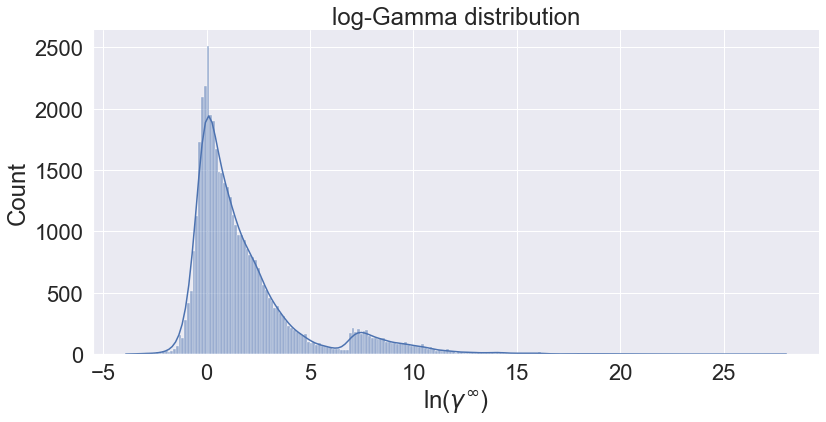

In [25]:
sns.displot(df, kde=True, x='log-gamma', legend=True, height=6, aspect=2)
plt.xlabel('ln($\gamma^\infty$)')
plt.title('log-Gamma distribution')

In [26]:
df['log-gamma'].describe()

count    44291.000000
mean         1.853645
std          2.827551
min         -3.912023
25%          0.067659
50%          0.947789
75%          2.459589
max         28.036486
Name: log-gamma, dtype: float64

### Temperature

Text(0.5, 1.0, 'Temperature distribution')

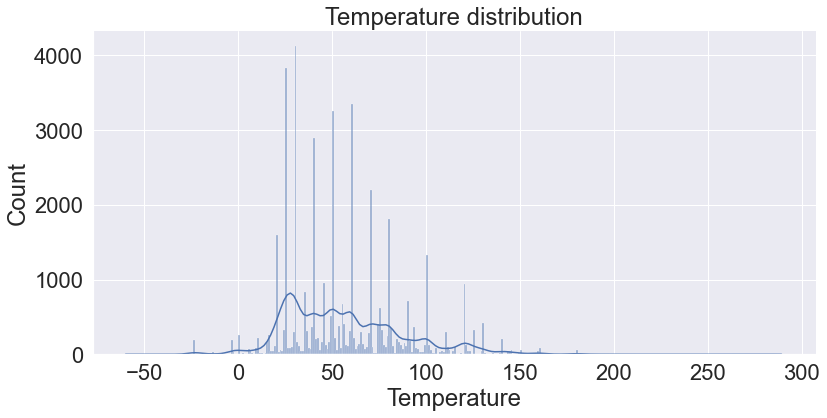

In [27]:
sns.displot(df, kde=True, x='T', legend=True, height=6, aspect=2, binwidth=1)
plt.xlabel('Temperature')
plt.title('Temperature distribution')

In [28]:
df['T'].describe()

count    44291.000000
mean        56.527875
std         32.060313
min        -60.000000
25%         30.000000
50%         50.000000
75%         75.000000
max        289.300000
Name: T, dtype: float64

In [29]:
# Number of unique temperatures
df['T'].nunique()

1087

In [30]:
# Number of bins

def get_bins(data, binwidth):
    bins = []
    min_val, max_val = min(data), max(data)
    data = sorted(data)
    
    bin_vals = []
    min_curr = min_val
    max_curr = min_curr + binwidth
    for d in data:
        if d >= min_curr and d < max_curr:
            bin_vals.append(d)
        else:
            bins.append(bin_vals)
            min_curr = max_curr
            max_curr = min_curr + binwidth
            bin_vals = []
    return bins

n_bins = len(get_bins(df['T'].tolist(), binwidth=1))
n_bins

294

#### Percentile of 90% temperature range

In [31]:
p1 = np.percentile(df['T'].tolist(), 5)
p1

20.0

In [32]:
p2 = np.percentile(df['T'].tolist(), 95)
p2

120.0

#### Number of systems measured in range larger than x

In [23]:
def get_unique_binary_systems(df):
    sys_key = df['Solvent_name'] + df['Solute_name']
    unique_sys={}
    for i in range(df.shape[0]):
        if sys_key.iloc[i] not in unique_sys:
            unique_sys[sys_key.iloc[i]] = [df['T'].iloc[i]]
        else:
            unique_sys[sys_key.iloc[i]].append(df['T'].iloc[i])
    return unique_sys


def get_nsys_Trange(unique_sys, T_range=20):
    sys_larger_range = {}
    for sys in unique_sys:
        unique_sys[sys] = sorted(unique_sys[sys])
        if max(unique_sys[sys]) - min(unique_sys[sys]) >= T_range:
            sys_larger_range[sys] = unique_sys[sys]
    return len(sys_larger_range)

In [34]:
unique_sys = get_unique_binary_systems(df)
print('Number of unique binary systems: ', len(unique_sys))

Number of unique binary systems:  15879


In [35]:
T_range = 5

nsys_range = get_nsys_Trange(unique_sys, T_range=T_range)
print('Number of systems measured in a larger range: ', nsys_range)
print('Percentage of systems measured in a larger range: ', np.round(nsys_range/len(unique_sys)*100,2), '%')

Number of systems measured in a larger range:  8989
Percentage of systems measured in a larger range:  56.61 %


In [36]:
T_range = 20

nsys_range = get_nsys_Trange(unique_sys, T_range=T_range)
print('Number of systems measured in a larger range: ', nsys_range)
print('Percentage of systems measured in a larger range: ', np.round(nsys_range/len(unique_sys)*100,2), '%')

Number of systems measured in a larger range:  7100
Percentage of systems measured in a larger range:  44.71 %


## Analysis of isothermal data

In [53]:
# Get bins that contain enough data

bins = get_bins(df['T'].tolist(), binwidth=1)

n_enough_data_bins = []

for b in bins:
    if len(b) > 1000:
        n_enough_data_bins.append(b)
        
len(n_enough_data_bins)



9

In [54]:
n_points_bin =[]
T_bin = []
for big_bin in n_enough_data_bins:
    n_points_bin.append(len(big_bin))
    T_bin.append(np.round(np.mean(big_bin), 2))

df_iso = pd.DataFrame([n_points_bin, T_bin])
df_iso = df_iso.transpose()
df_iso.columns = ['Number of points', 'T']
df_iso 

,Number of points,T
0,1589.0,20.01
1,3823.0,25.01
2,4123.0,30.04
3,2897.0,40.05
4,3251.0,50.05
5,3353.0,60.07
6,2198.0,70.19
7,1814.0,80.10
8,1326.0,100.04


## Ionic liquids and molecular compounds

In [61]:
smiles_lst = df_c['SMILES'].tolist()
names_lst = df_c['NAME'].tolist()

mols_or_ionic = []
ionic_dict ={}
molecular_dict={}

for smiles, name in zip(smiles_lst, names_lst):
    if '.' in smiles:
        mols_or_ionic.append('ionic')
        ionic_dict[name] = 'ionic'
    else:
        mols_or_ionic.append('molecular')
        molecular_dict[name] = 'molecular'
        
df_c['molecular/ionic'] = mols_or_ionic
df_c.to_csv('../data/interim/compounds_classified.csv', index=False)


Percentage of categories
------------------------------
Molecular:  94.97 % ( 1585 )
Ionic:  5.03 % ( 84 )


Text(0, 0.5, '')

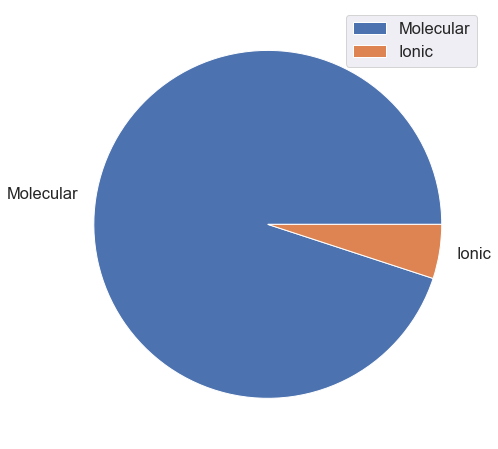

In [62]:
category = df_c.groupby('molecular/ionic').count()['Internal_ID']
print('\nPercentage of categories')
print('-'*30)
print('Molecular: ', np.round(category['molecular']/(category['molecular']+category['ionic'])*100, 2),'%', '(',category['molecular'] ,')')
print('Ionic: ', np.round(category['ionic']/(category['molecular']+category['ionic'])*100, 2),'%', '(',category['ionic'] ,')')

df_pie = pd.DataFrame({'category': [category['molecular'], category['ionic']]},
                  index=['Molecular', 'Ionic'])
df_pie.plot.pie(y='category', figsize=(8, 8))
plt.ylabel('')

#### How many molecular/ionic data?

In [63]:
n_points = df.shape[0]
n_molecular = 0
n_ionic = 0

for i in range(n_points):
    if df['Solvent_name'].iloc[i] in ionic_dict or df['Solute_name'].iloc[i] in ionic_dict:
        n_ionic += 1
    else:
        n_molecular += 1
print('Datapoints')
print('-'*30)
print('Molecular: ', np.round(n_molecular/n_points*100,2), '%', '(', n_molecular, ')')
print('Ionic: ', np.round(n_ionic/n_points*100,2), '%', '(', n_ionic, ')')

Datapoints
------------------------------
Molecular:  90.81 % ( 40219 )
Ionic:  9.19 % ( 4072 )


In [16]:
df_molecular = pd.read_csv('../data/interim/molecular_data.csv')
print('Number of unique solvents: ', df_molecular['Solvent_name'].nunique())
print('Number of unique solutes: ', df_molecular['Solute_name'].nunique())

Number of unique solvents:  866
Number of unique solutes:  1032


In [17]:
df_molecular['Binary_systems'] = df_molecular['Solvent_name'] + '_' + df_molecular['Solute_name']
print('Number of unique binary-systems: ', df_molecular['Binary_systems'].nunique())

Number of unique binary-systems:  14663


### Temperature statistics for the molecular dataset

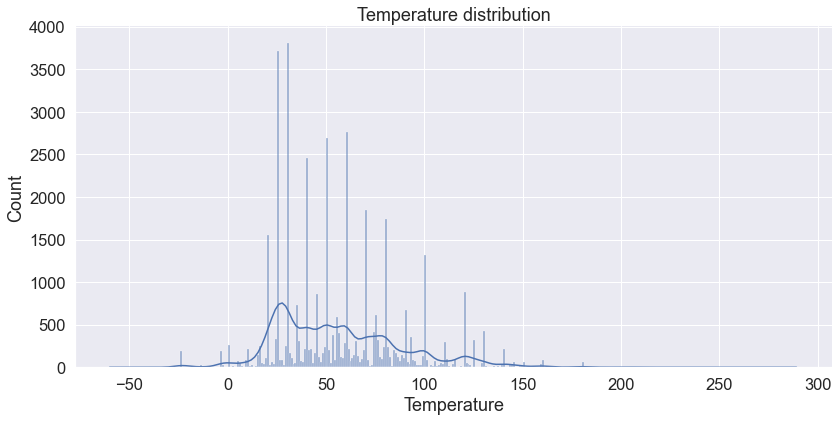

In [41]:
fig = sns.displot(df_molecular, kde=True, x='T', legend=True, height=6, aspect=2, binwidth=1)
plt.xlabel('Temperature')
plt.title('Temperature distribution')
fig.savefig('../figures/SupportingInformation/temperature_distribution.png', dpi=300, format='png')

In [19]:
df_molecular['T'].describe()

count    40219.000000
mean        56.568573
std         32.815393
min        -60.000000
25%         30.000000
50%         50.000000
75%         76.000000
max        289.300000
Name: T, dtype: float64

In [20]:
p1 = np.percentile(df_molecular['T'].tolist(), 5)
p1

20.0

In [21]:
p2 = np.percentile(df_molecular['T'].tolist(), 95)
p2

120.0

In [24]:
unique_sys = get_unique_binary_systems(df_molecular)
print('Number of unique binary systems: ', len(unique_sys))

T_range = 20

nsys_range = get_nsys_Trange(unique_sys, T_range=T_range)
print('Number of systems measured in a larger range: ', nsys_range)
print('Percentage of systems measured in a larger range: ', np.round(nsys_range/len(unique_sys)*100,2), '%')

Number of unique binary systems:  14663
Number of systems measured in a larger range:  6326
Percentage of systems measured in a larger range:  43.14 %


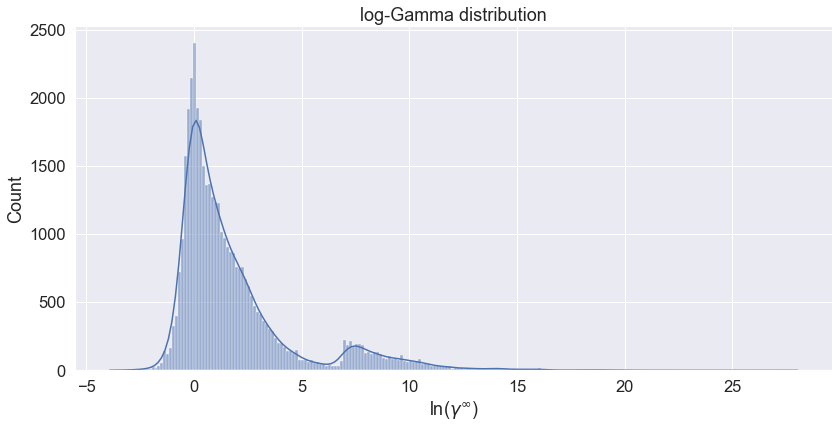

In [40]:
fig = sns.displot(df_molecular, kde=True, x='log-gamma', legend=True, height=6, aspect=2)
plt.xlabel('ln($\gamma^\infty$)')
plt.title('log-Gamma distribution')
fig.savefig('../figures/SupportingInformation/log-gamma_distribution.png', dpi=300, format='png')

In [27]:
df_molecular['log-gamma'].describe()

count    40219.000000
mean         1.886634
std          2.905130
min         -3.912023
25%          0.058269
50%          0.928219
75%          2.443650
max         28.036486
Name: log-gamma, dtype: float64

In [37]:
negative_dev = df_molecular['log-gamma']>0
negative_dev.value_counts()

True     31091
False     9128
Name: log-gamma, dtype: int64

## Classyfire statistics

In [42]:
df_c_m = pd.read_csv('../data/interim/molecular_compounds.csv')
df_c_i = pd.read_csv('../data/interim/ionic_compounds.csv')

In [43]:
print('Number of unique molecular compounds: ', df_c_m['NAME'].nunique())
print('Number of unique ionic compounds: ', df_c_i['NAME'].nunique())

Number of unique molecular compounds:  1585
Number of unique ionic compounds:  84


In [44]:
def counter_classification(df):
    taxonomies = ['molecular_framework', 'description', 'kingdom', 'superclass', 'class', 'subclass', 'direct_parent']
    count_dict = {}
    for tax in taxonomies:
        count_dict[tax] = df[tax].nunique()
    return pd.DataFrame(count_dict.items(), columns=['Taxonomy', 'Count'])

def get_most_popular_classes(df, n_popular=15):
    taxonomies = ['molecular_framework', 'description', 'kingdom', 'superclass', 'class', 'subclass', 'direct_parent']
    popular_classes = {}
    for tax in taxonomies:
        popular_classes[tax] = df[tax].value_counts()[:n_popular]
    return popular_classes

def get_categories(df, taxonomy):
    counting = df[taxonomy].value_counts()
    return pd.DataFrame({taxonomy:counting})

#### Statistics of compounds

Hierarchical chemical taxonomy

1. **Kingdom**: Organic vs. Inorganic

2. **Superclass**: Generic categories of compounds with general structural identifiers (e.g. organic acids and derivatives, phenylpropanoids and polyketides, organometallic compounds, homogeneous metal compounds)

3. **Class**:More specific chemical categories with more specific and recognizable structural features

4. **Subclass**: More detailed categories


- **Molecular framework**: Overall description of the compound in terms of aliphaticity/aromaticity and number of cycles
- **Direct parent**: Category defined by the largest structural feature that describes the compound.

#### Molecular compounds

In [45]:
df_taxonomies = counter_classification(df_c_m)
df_taxonomies

,Taxonomy,Count
0,molecular_framework,9
1,description,314
2,kingdom,2
3,superclass,19
4,class,91
5,subclass,166
6,direct_parent,314


In [46]:
df_category = get_categories(df_c_m, 'class')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_category)

,class
Benzene and substituted derivatives,271
Organooxygen compounds,193
Fatty Acyls,136
Organonitrogen compounds,113
Carboxylic acids and derivatives,104
Saturated hydrocarbons,103
Unsaturated hydrocarbons,67
Prenol lipids,39
Organofluorides,32
Phenols,30


In [75]:
def save_latextable(df, filename):
    """ddataframe to latex"""
    LATEX_TABLE = r'''\documentclass{{standalone}}
                        \usepackage{{booktabs}}
                        \usepackage{{multirow}}
                        \usepackage{{graphicx}}
                        \usepackage{{xcolor,colortbl}}
                        \begin{{document}}
                        {}
                        \end{{document}}
                        '''
    a_str = df.to_latex(multicolumn=True, multirow=True, escape=False, index=False)
    with open(filename, 'w') as f:
        f.write(LATEX_TABLE.format(a_str))

In [76]:
df1 = df_category.iloc[:46].index.tolist()
df1_values = df_category['class'].iloc[:46].tolist()
df2 = df_category.iloc[46:].index.tolist()
df2_values = df_category['class'].iloc[46:].tolist()

df2.append('')
df2_values.append('')

df3 = pd.DataFrame({'class1': df1,
                   'values1': df1_values,
                   'class2': df2,
                   'values2': df2_values})
df3

,class1,values1,class2,values2
0,Benzene and substituted derivatives,271,Phenanthrenes and derivatives,4
1,Organooxygen compounds,193,Lactams,4
2,Fatty Acyls,136,Epoxides,4
3,Organonitrogen compounds,113,Keto acids and derivatives,3
4,Carboxylic acids and derivatives,104,Sulfonyls,3
5,Saturated hydrocarbons,103,Other non-metal organides,3
6,Unsaturated hydrocarbons,67,Azobenzenes,3
7,Prenol lipids,39,Dioxanes,3
8,Organofluorides,32,Homogeneous other non-metal compounds,3
9,Phenols,30,Pyrroles,3


In [77]:
save_latextable(df3, '../references/ChemicalClasses.txt')

#### Ionic compounds

In [69]:
df_taxonomies = counter_classification(df_c_i)
df_taxonomies

,Taxonomy,Count
0,molecular_framework,2
1,description,20
2,kingdom,1
3,superclass,9
4,class,12
5,subclass,13
6,direct_parent,20


In [70]:
df_category = get_categories(df_c_i, 'class')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_category)

,class
Azoles,39
Pyridines and derivatives,9
Organic sulfonic acids and derivatives,9
Organonitrogen compounds,7
Alkyl halides,6
Benzene and substituted derivatives,4
Fatty Acyls,2
Tetraalkylphosphonium compounds,2
Organic phosphoric acids and derivatives,1
Organic oxoanionic compounds,1


### Systems in molecular data

In [71]:
df_data_m = pd.read_csv('../data/interim/molecular_data.csv')
df_data_m['key_class'].nunique()

841

In [72]:
df_category = get_categories(df_data_m, 'key_class')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_category)

,key_class
Organooxygen compounds_Saturated hydrocarbons,2030
Benzene and substituted derivatives_Saturated hydrocarbons,1944
Saturated hydrocarbons_Saturated hydrocarbons,1214
Benzene and substituted derivatives_Benzene and substituted derivatives,1121
Organooxygen compounds_Organooxygen compounds,1100
Saturated hydrocarbons_Organooxygen compounds,1007
Homogeneous other non-metal compounds_Organooxygen compounds,990
Homogeneous other non-metal compounds_Benzene and substituted derivatives,874
Organooxygen compounds_Benzene and substituted derivatives,865
Organooxygen compounds_Unsaturated hydrocarbons,807


In [73]:
# Count single systems to be placed in training
df_singles = df_category[df_category['key_class'] == 1]
df_singles.shape[0]

118

### Systems in ionic data

In [74]:
df_data_i = pd.read_csv('../data/interim/ionic_data.csv')
df_data_i['key_class'].nunique()

98

In [75]:
df_category = get_categories(df_data_i, 'key_class')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_category)

,key_class
Azoles_Organooxygen compounds,806
Azoles_Saturated hydrocarbons,695
Azoles_Benzene and substituted derivatives,490
Azoles_Unsaturated hydrocarbons,463
Azoles_Alkyl halides,118
Organic sulfonic acids and derivatives_Organooxygen compounds,112
Azoles_Fatty Acyls,110
Pyridines and derivatives_Organooxygen compounds,100
Pyridines and derivatives_Saturated hydrocarbons,89
Azoles_NA,80


In [76]:
# Count single systems to be placed in training
df_singles = df_category[df_category['key_class'] == 1]
df_singles.shape[0]

10

# Train and test splitting

### Molecular

In [77]:
pd.DataFrame(df_data_m['split'].value_counts(normalize=True))*100

,split
train,79.338124
test,20.661876


In [78]:
pd.DataFrame(df_data_m['split'].value_counts())

,split
train,31909
test,8310


Text(0.5, 1.0, 'log-Gamma distribution - Molecular systems')

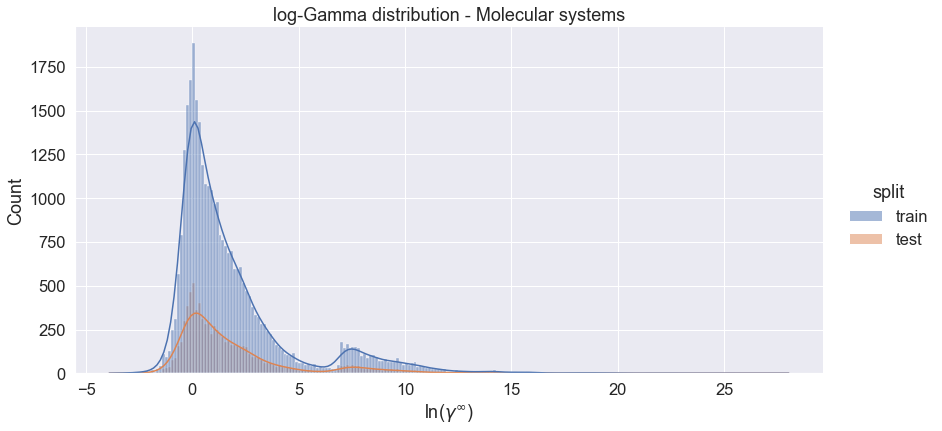

In [79]:
sns.displot(df_data_m, kde=True, x='log-gamma', legend=True, height=6, aspect=2, hue="split")
plt.xlabel('ln($\gamma^\infty$)')
plt.title('log-Gamma distribution - Molecular systems')

Text(0.5, 1.0, 'Temperature distribution - Molecular systems')

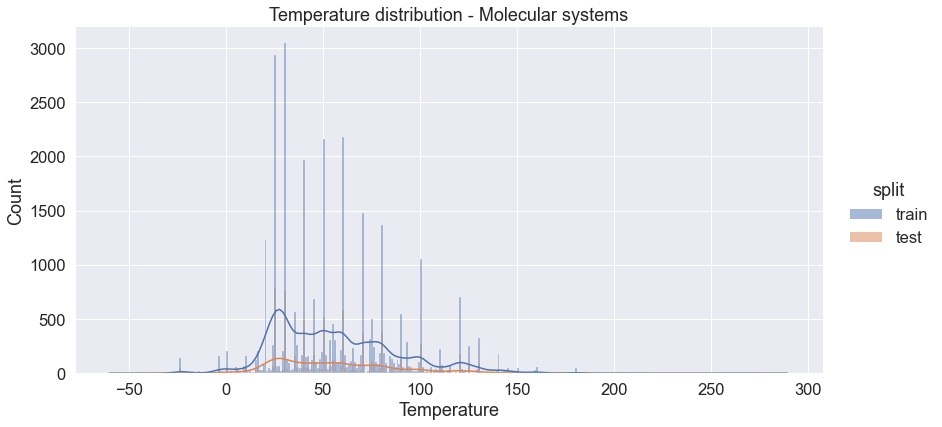

In [80]:
sns.displot(df_data_m, kde=True, x='T', legend=True, height=6, aspect=2, binwidth=1, hue="split")
plt.xlabel('Temperature')
plt.title('Temperature distribution - Molecular systems')

### Ionic

In [81]:
pd.DataFrame(df_data_i['split'].value_counts(normalize=True))*100

,split
train,79.248527
test,20.751473


In [82]:
pd.DataFrame(df_data_i['split'].value_counts())

,split
train,3227
test,845


Text(0.5, 1.0, 'log-Gamma distribution - Ionic systems')

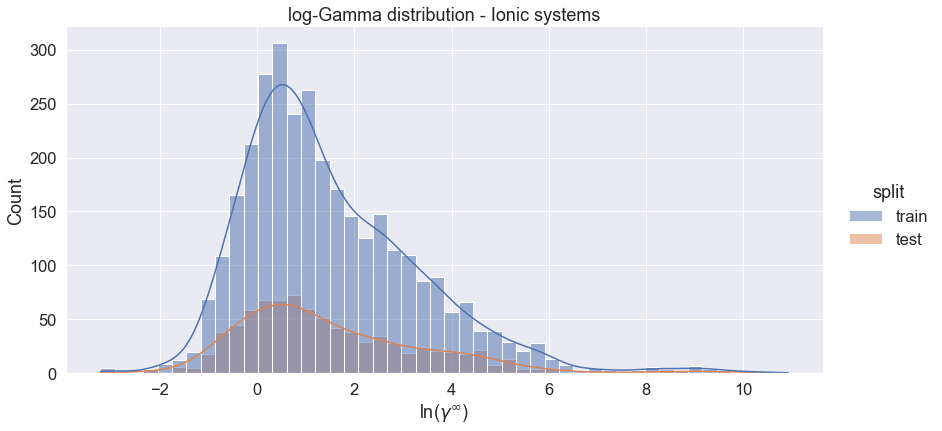

In [83]:
sns.displot(df_data_i, kde=True, x='log-gamma', legend=True, height=6, aspect=2, hue="split")
plt.xlabel('ln($\gamma^\infty$)')
plt.title('log-Gamma distribution - Ionic systems')

Text(0.5, 1.0, 'Temperature distribution - Ionic systems')

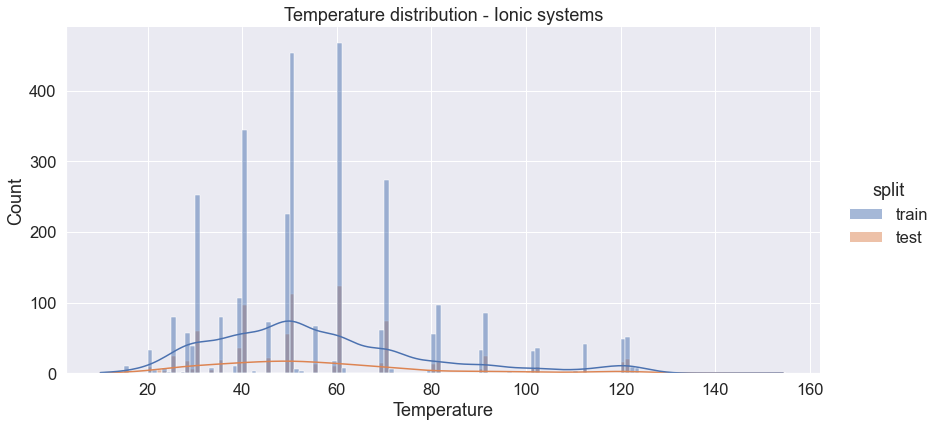

In [84]:
sns.displot(df_data_i, kde=True, x='T', legend=True, height=6, aspect=2, binwidth=1, hue="split")
plt.xlabel('Temperature')
plt.title('Temperature distribution - Ionic systems')